In [4]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math
import time

import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import linear_model
from skopt import gp_minimize
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=3, suppress=True)
pd.options.mode.chained_assignment = None

In [5]:
race_type = 'R'
# race_type = 'G'
# race_type = 'H'

bet_type = 'W'
# bet_type = 'P'

pred = '{}_pred'.format(bet_type)
prob = '{}_prob'.format(bet_type)
bet = '{}_bet'.format(bet_type)

In [6]:
engine = create_engine('sqlite:///../../data/race.db')
conn = engine.connect()
dfoo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfoo)))

72206 races loaded!


In [7]:
dfoo = dfoo.sort_values('race_start_time')
print('{} races sorted!'.format(len(dfoo)))

72206 races sorted!


In [8]:
dfo = dfoo.loc[dfoo['race_type'].isin([race_type])]
print('{} {} races for {} betting!'.format(len(dfo), race_type, bet_type))

23864 R races for W betting!


In [9]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
print('results and runners decoded')

results and runners decoded


In [10]:
def process_strategy(dfp, strategy, x):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    balance = 1000
    balance_tag = balance
    rnd = 1
    expected_profit = balance_tag * 0.1
    running_profit = 0
    goals = 0

    book = []
    for _, race in dfp.iterrows():
        # increment rnd and up the bar for expected
        short = expected_profit - running_profit
        
#         print(race['num_runners'])
        runners = race['runners']
        
        # drop scratched
        runners = [r for r in runners if r['has_odds']]
        if not runners:
            continue

        try:
            runners = strategy(runners, short, race_type, bet_type, x)
        except Exception as e:
            print(runners)
            raise
            
        outcome = bet_results(runners)
        running_profit += outcome['profit']
        balance += outcome['profit']            

        outcome['balance'] = balance
        outcome['balance_tag'] = balance_tag
        outcome['running_profit'] = running_profit
        outcome['rnd'] = rnd
        outcome['expected_profit'] = expected_profit
        outcome['goals'] = goals
        book.append(outcome)
        
        if balance <= 0:
            print('!', end='')
            break

        # increment expected
        rnd += 1
        expected_profit += 0.001 * balance_tag

        # check if goal reached
        if running_profit >= expected_profit:
            goals += 1
            running_profit = 0
            rnd = 0
            balance_tag = balance
            
    book_df = pd.DataFrame(book)
    return book_df

In [11]:
def bet_results(runners):
    """get results from bets"""
    bet = '{}_bet'.format(bet_type)
    place_cutoff = 3 if len(runners) >= 8 else 2

    bets = [r[bet] for r in runners]

    # profit start with loss of bet made
    outcome = {
        'success': 0,
        'total_bets': sum(bets),
        'profit': -sum(bets),
        'num_bets': len([b for b in bets if b]),
        'num_runners': len(runners),
    }
    
    if outcome['total_bets']:
        for i, runner in enumerate(runners):
            if runner[bet]:
                if bet_type == 'W':
                    if int(runner['finishingPosition']) == 1:
                        outcome['success'] = 1
                        # profit will be payout added against inital deduction
                        # winnings is the bet made times the odds
                        winnings = runner[bet] * runner['win_odds']
                        outcome['profit'] += winnings
                    break
                elif bet_type == 'P':
                    if 1 <= int(runner['finishingPosition']) <= place_cutoff:
                        # success is how correct each placement was
                        outcome['success'] += 1 / num_bets
                        # profit will be return added and offset against inital deduction
                        # winnings is the bet made times the odds
                        winnings = runner[bet] * runner['place_odds']
                        outcome['profit'] += winnings
    return outcome

In [12]:
def bet_spread(runners, short, race_type, bet_type, x):
    """split expected progressively"""
    key_bet = '{}_bet'.format(bet_type)

    if bet_type == 'W':
        key_odds = 'win_odds'
        key_scale = 'fws'
    else:
        key_odds = 'place_odds'
        key_scale = 'fps'

    # sort runners from favourite to underdog
    runners.sort(key=lambda r: r.get(key_scale, 0), reverse=True)
    
    # reset bets
    for runner in runners:
        runner[key_bet] = 0

    short /= 50

    # make bet on favourite
    if runners[0][key_scale] > x:
        odds = runners[0][key_odds]
        bet_amt = max([1, short / (odds - 1)])
        runners[0][key_bet] = bet_amt

    return runners

In [13]:
# book_df = process_strategy(dfo, bet_spread)
# print(book_df.balance.iloc[-1])
# print(book_df.tail(-2))

In [14]:
def f(x):
    print('.', end='')
    df_sample = dfo.sample(frac=0.5)
#     print('sample size of {}/{}'.format(len(df_sample), len(dfo)))
    book_df = process_strategy(df_sample, bet_spread, x)
#     print(book_df)
    if not len(book_df):
        return 0
    profit = book_df.profit.sum()
    return profit / len(dfo) * -1


print('optimizing', end='')
time_start = time.time()
x_slice = np.s_[0:1:20j]
x, *grid = sp.optimize.brute(f, ranges=(x_slice,), full_output=True)

# SKopt
# res = gp_minimize(f, [(0., 5.), (0., 5.)], n_calls=200, n_jobs=8)
# print(res)

print('done: took {:.0f}s'.format((time.time() - time_start)), flush=True)
# print('x: {}'.format(x))
# print('grid: {}'.format(grid))

optimizing.....!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!........done: took 19s


In [15]:
print('race type: {}'.format(race_type))
print('bet type: {}'.format(bet_type))
print('x: {}'.format(x))
df = process_strategy(dfo, bet_spread, x)
print('${:.2f} profit per race'.format(df.profit.sum() / len(dfo)))
print('{:.0f}% of races {} / {}'.format(df.num_bets.sum() / len(dfo) * 100, df.num_bets.sum(), len(dfo)))
print('{:.2f}% win rate'.format(book_df.success.mean() * 100))
book_df

race type: R
bet type: W
x: [ 0.]
$0.00 profit per race
0% of races 0 / 23864


NameError: name 'book_df' is not defined

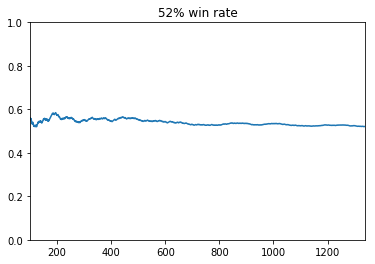

In [146]:
df['ones'] = np.ones(len(df))
df['win_rate'] = df.success.cumsum() / df.ones.cumsum()
win_title = '{:.0f}% win rate'.format(df.win_rate.iloc[-1] * 100)
df.win_rate.plot(title=win_title, xlim=(100), ylim=(0, 1))

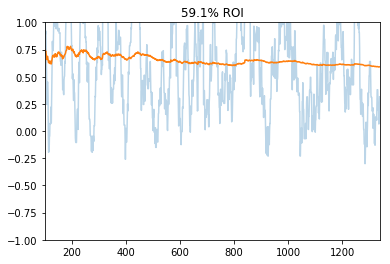

In [147]:
# ROI
roi = df.profit.rolling(20).sum() / df.bet_chunk.rolling(20).sum()
roi.plot(xlim=(100), ylim=(-1, 1), alpha=0.3)
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.1f}% ROI'.format(roi.iloc[-1] * 100)
roi.plot(xlim=(100), ylim=(-1, 1), title=roi_title)

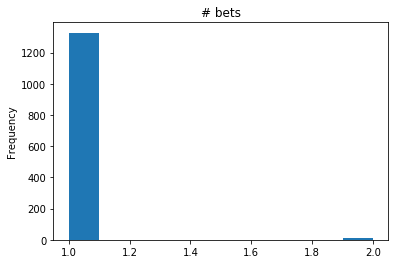

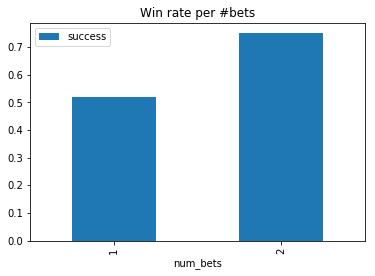

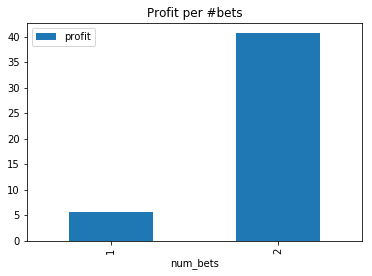

In [148]:
# profit per num bets 
df.num_bets.plot(kind='hist', title='# bets')
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='Win rate per #bets')
groups.plot(kind='bar', y='profit', title='Profit per #bets')

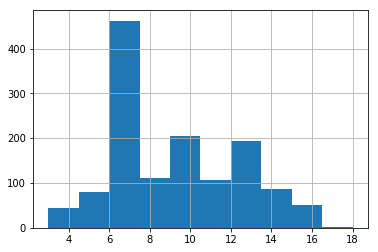

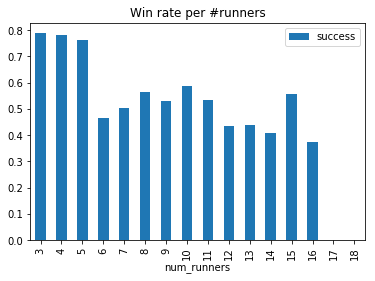

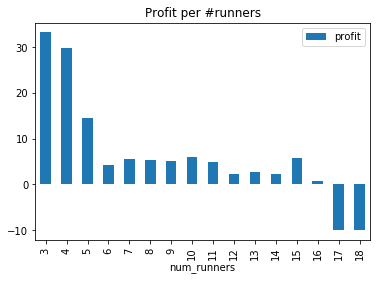

In [149]:
# profit per num runners
df.num_runners.hist()
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='Win rate per #runners')
groups.plot(kind='bar', y='profit', title='Profit per #runners')

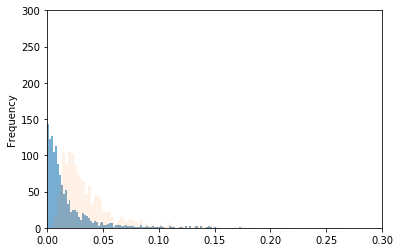

In [150]:
# max diff
df.win_diff.plot(kind='hist', bins=100, alpha=0.6, ylim=(0, 300), xlim=(0, 0.3))
df.max_diff.plot(kind='hist', bins=100, alpha=0.1, ylim=(0, 300), xlim=(0, 0.3))

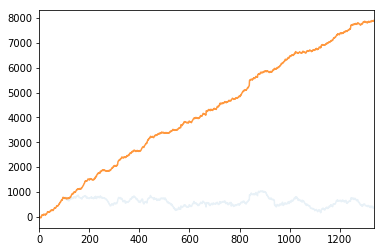

In [151]:
# df.profit.plot(kind='hist', bins=50, xlim=(-5), ylim=(0, 140))
df.profit.rolling(100).sum().plot(alpha=0.1)
df.profit.cumsum().plot(alpha=0.8)

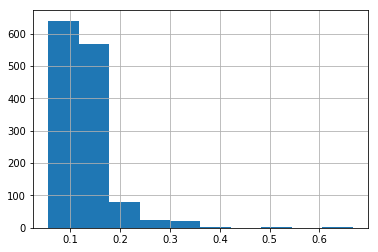

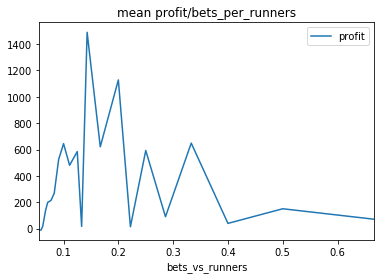

In [152]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

In [153]:
# # pred vs scale
# df['prob_vs_scale'] = df.pr / df.num_runners
# df['bets_vs_runners'].hist(bins=10)
# groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
# groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

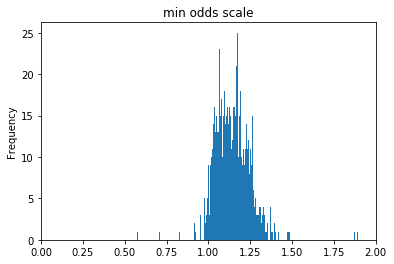

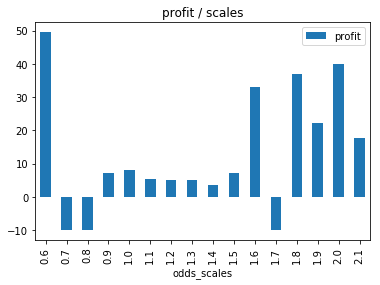

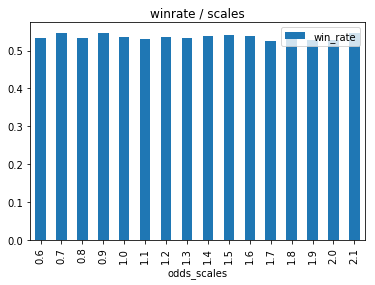

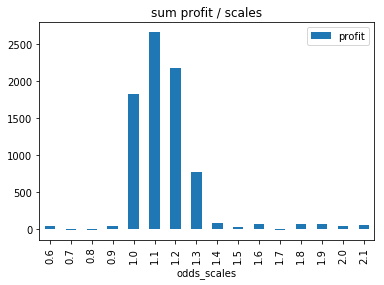

In [154]:
df.odds_scales.plot(kind='hist', bins=500, title='min odds scale', xlim=(0, 2))
groups = df.groupby(df['odds_scales'].apply(lambda x: round(x, 1))).mean()
groups.plot(kind='bar', y='profit', title='profit / scales')
groups.plot(kind='bar', y='win_rate', title='winrate / scales')

groups_sum = df.groupby(df['odds_scales'].apply(lambda x: round(x, 1))).sum()
groups_sum.plot(kind='bar', y='profit', title='sum profit / scales')